# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import authentic_performance as ap
from scipy.stats import uniform, norm
import networkx as nx
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch, os
from sklearn.model_selection import train_test_split
import torch_geometric.utils as utils
from torch.utils.data import DataLoader
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
import pickle

In [3]:
with open("data/synthetic-dataset/random-net-dumb-fraudster/test/0.0/G_0.pickle", "rb") as f:
        G = pickle.load(f)
N = G.number_of_nodes()
LEN_TRAIN_DATASET = len(list(os.walk("data/synthetic-dataset/random-net-no-fraudster/train"))[0][2])
LEN_TEST_DATASET = len(list(os.walk("data/synthetic-dataset/random-net-no-fraudster/test"))[0][2])
FRAUDSTER_INDEX = [x for x, y in nx.get_node_attributes(G, "fraud").items() if y][0]
LIST_FRAUD_PROBABILITIES = sorted([float(x) for x in list(os.walk(r"data/synthetic-dataset/random-net-dumb-fraudster/test"))[0][1]])
print(f"N = {N}\nLEN_TRAIN_DATASET = {LEN_TRAIN_DATASET}\nLEN_TEST_DATASET = {LEN_TEST_DATASET}\nFRAUDSTER_INDEX = {FRAUDSTER_INDEX}\nLIST_FRAUD_PROBABILITIES = {LIST_FRAUD_PROBABILITIES}")

N = 100
LEN_TRAIN_DATASET = 100
LEN_TEST_DATASET = 100
FRAUDSTER_INDEX = 50
LIST_FRAUD_PROBABILITIES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [4]:
# to save results we will use these lists

l_ranking_performance = []
l_fraudster_rankings = []

# 1 Random network

## 1.1 Ranking performance

In [5]:
# delta degrees

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    ratings = ap.rate_deltaDegrees(G)
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                              "method":"delta degrees",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 711.1, std:53.2
Spearman correlation 	 mean:0.897, std:0.015


In [6]:
# f_alpha_t

l_df = []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        l_df.append(df)
df = pd.concat(l_df)
X, y = torch.from_numpy(df[["wins","losses","draws"]].values).float(), torch.from_numpy(df["strength"].values).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ap.WinLossDraw()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)
l_param = []
l_train_loss = []
l_test_loss = []
for epoch in range(100):
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    l_train_loss.append(loss_train.item())
    l_param.append((model.alpha.item(), model.t.item()))
    with torch.no_grad():
        pred = model(X_test).flatten()
        loss_test = criterion(pred, y_test)
        l_test_loss.append(loss_test.item())
        
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    t_ratings = model(torch.from_numpy(ap.convert_graphToDataFrame(G)[["wins", "losses", "draws"]].values))
    ratings = t_ratings.detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                              "method":"f_alpha_t",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

model_f_alpha_t = model  # save for later
del model

Kendall tau distance 	 mean: 737.3, std:82.2
Spearman correlation 	 mean:0.873, std:0.034


In [7]:
# MLP

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

model = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    df = ap.convert_graphToDataFrame(G)
    ratings = model(torch.from_numpy(df[["wins", "losses", "draws"]].values).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                              "method":"MLP",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

model_mlp = model  # save for later
del model

Kendall tau distance 	 mean: 632.6, std:58.0
Spearman correlation 	 mean:0.913, std:0.016


In [8]:
# MLP neighborhood information

l_X, l_y = [], []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    adjacency = nx.adjacency_matrix(G).todense()
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    l_X.append(X)
    l_y.append(y)
X = torch.tensor(np.concatenate(l_X), dtype=torch.float)
y = torch.tensor(np.concatenate(l_y), dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

model = MLP(4, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())

# fig, ax = plt.subplots(1,2)
# plt.suptitle("Losses")
# ax[0].plot(l_train_loss, label="train")
# ax[0].set_title("Train")
# ax[1].plot(l_test_loss, label="test")
# ax[1].set_title("Test")

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    adjacency = nx.adjacency_matrix(G).todense();
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    
    # mlp with neighbourhood information
    ratings = model(torch.from_numpy(X).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)


a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)

print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
l_ranking_performance.append({"network":"random",
                                "method":"MLP_neighbourhood",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

model_mlp_neighbourhood = model  # save for later
del model

/tmp/ipykernel_71406/1608351712.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_71406/1608351712.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_71406/1608351712.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1608351712.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1608351712.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/

Kendall tau distance 	 mean: 485.6, std:44.2
Spearman correlation 	 mean:0.948, std:0.010


/tmp/ipykernel_71406/1608351712.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1608351712.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1608351712.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1608351712.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1608351712.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/

In [9]:
# PageRank
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    pr = nx.pagerank(G)
    ratings = np.array(list(pr.values()))
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
    
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                                "method":"PageRank",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 614.0, std:54.2
Spearman correlation 	 mean:0.916, std:0.015


In [10]:
# GCN

class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_features)
        # self.conv2 = GCNConv(hidden_features, hidden_features)
        self.conv_out = GCNConv(hidden_features, 1)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.ReLU()(self.conv1(x, edge_index))
        # x = torch.nn.ReLU()(self.conv2(x, edge_index))
        x = self.conv_out(x, edge_index)
        return torch.nn.Sigmoid()(x)

def convert_nxToPyGData(G):
    data = pyg.utils.convert.from_networkx(G)
    data.id = torch.tensor(list(G.nodes()))
    data.x = torch.permute(torch.concat((pyg.utils.degree(data.edge_index[0], num_nodes=data.num_nodes).view(1,-1),
                                        pyg.utils.degree(data.edge_index[1], num_nodes=data.num_nodes).view(1,-1))),(1,0)).float()
    data.y = data.strength.float()
    return data

def evaluate():
    loss = 0
    for data in dataloader_test:
        output = model(data).flatten()
        loss += torch.nn.MSELoss(reduction='sum')(output, data.y)
    return (loss / (len(dataloader_test.sampler)*N)).item()

dataset = []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    data = convert_nxToPyGData(G)
    dataset.append(data)
dataloader_train = pyg.loader.DataLoader(dataset[:int(len(dataset)*0.8)], batch_size=10, shuffle=True)
dataloader_test = pyg.loader.DataLoader(dataset[int(len(dataset)*0.8):], batch_size=10, shuffle=True)
model = GCN(in_features=data.x.shape[1], hidden_features=100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

l_train_loss, l_test_loss = [], []
for epoch in range(n_epochs):
    for data in dataloader_train:
        optimizer.zero_grad()
        output = model(data).flatten()
        loss_train = criterion(output, data.y)
        loss_train.backward()
        optimizer.step()
        l_train_loss.append(loss_train.item())
    loss_test = evaluate()
    l_test_loss.append(loss_test)

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    data = convert_nxToPyGData(G)
    ratings = model(data).flatten()[torch.argsort(data.id)].detach().numpy()  # reordering so that nodes are ordered by their id
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                                "method":"GCN",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

model_gcn = model  # save for later
del model

Kendall tau distance 	 mean: 788.7, std:87.7
Spearman correlation 	 mean:0.873, std:0.027


## 1.2 Fraud sensitivity

### 1.2.1 Dumb fraudster

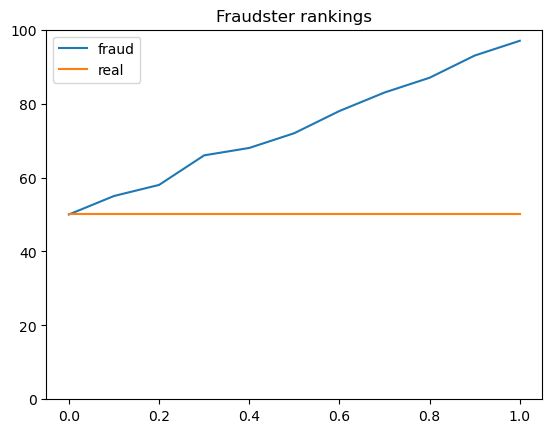

In [11]:
# delta degrees

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        ratings = ap.rate_deltaDegrees(G)
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"delta degrees",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

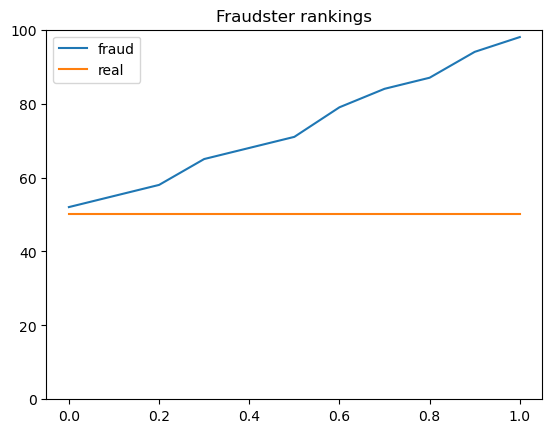

In [12]:
# f_alpha_t

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_f_alpha_t(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"f_alpha_t",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

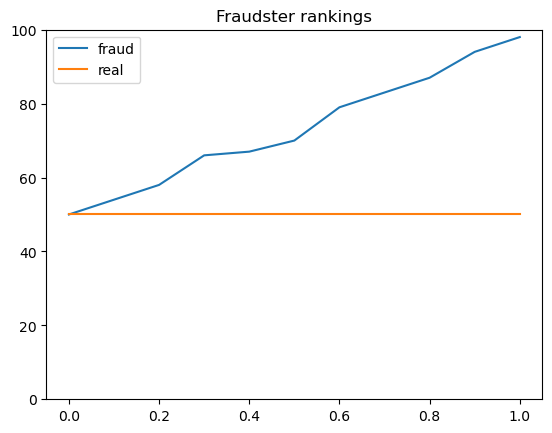

In [13]:
# MLP

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_mlp(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"MLP",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

/tmp/ipykernel_71406/2778410071.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/2778410071.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/2778410071.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/2778410071.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/2778410071.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp

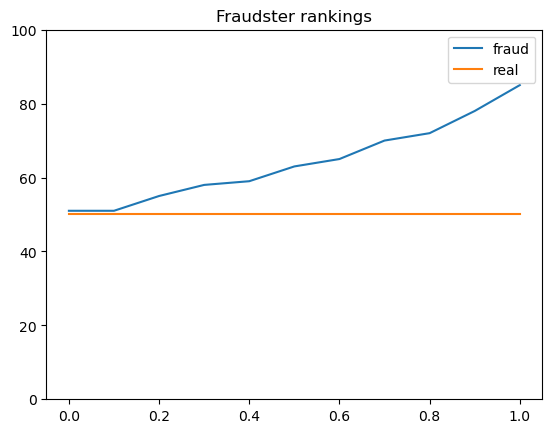

In [14]:
# MLP neighbourhood information

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model_mlp_neighbourhood(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        ratings = s.values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"MLP_neighbourhood",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

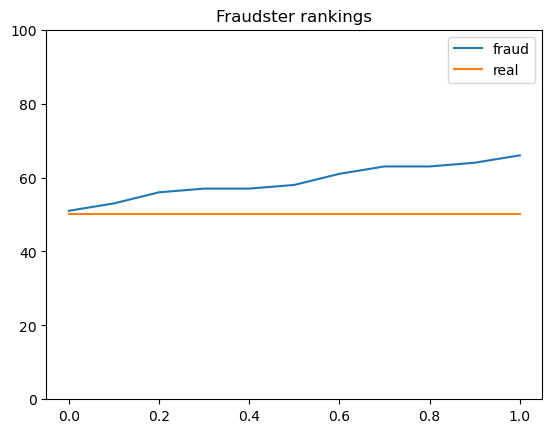

In [15]:
# PageRank

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        pr = nx.pagerank(G)
        ratings = pd.Series(pr).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"PageRank",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

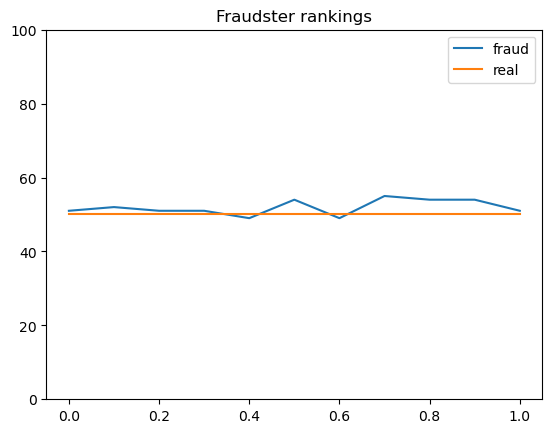

In [16]:
# GCN

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        data = convert_nxToPyGData(G)
        ratings = pd.Series(model_gcn(data).flatten().detach().numpy(), index=data.id.detach().numpy()).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])

l_fraudster_rankings.append({"network":"random",
                             "method":"GCN",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

### 1.2.2 Malicious fraudster

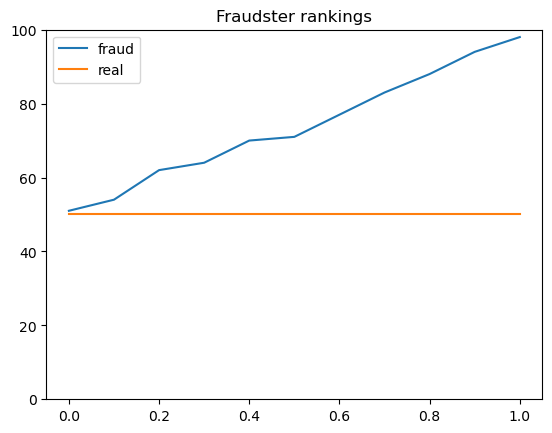

In [17]:
# delta degrees

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        ratings = ap.rate_deltaDegrees(G)
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"delta degrees",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

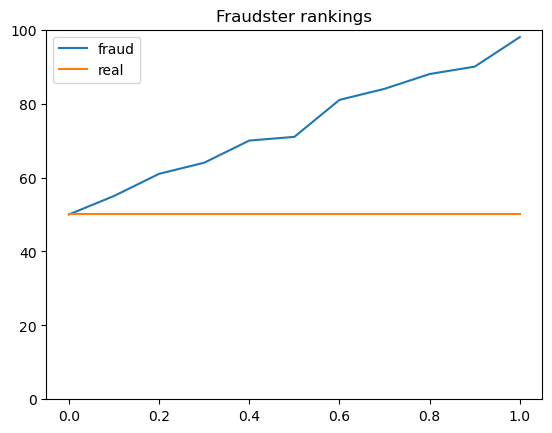

In [18]:
# f_alpha_t

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_f_alpha_t(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"f_alpha_t",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

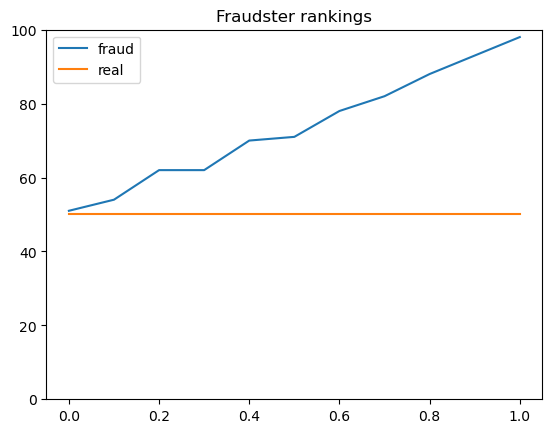

In [19]:
# MLP

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_mlp(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"MLP",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

/tmp/ipykernel_71406/895285199.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/895285199.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/895285199.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/895285199.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/895285199.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipyk

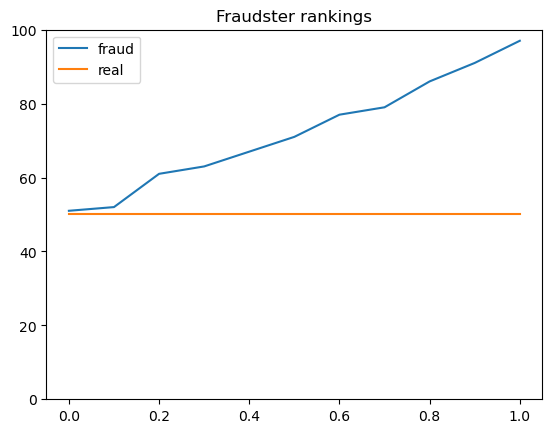

In [20]:
# MLP neighbourhood information

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model_mlp_neighbourhood(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        ratings = s.values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"MLP_neighbourhood",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

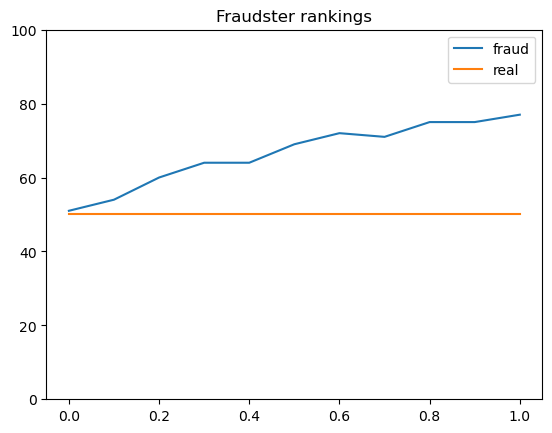

In [21]:
# PageRank

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        pr = nx.pagerank(G)
        ratings = pd.Series(pr).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"random",
                             "method":"PageRank",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

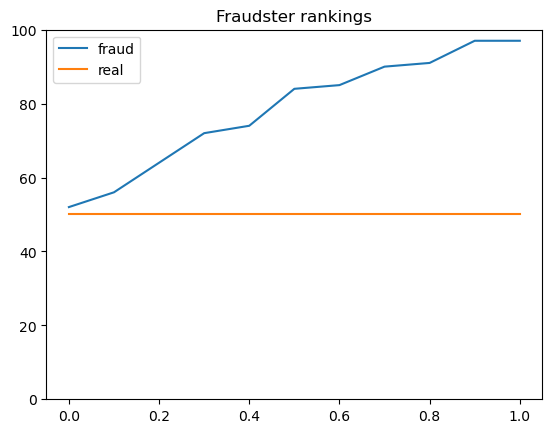

In [22]:
# GCN

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/random-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        data = convert_nxToPyGData(G)
        ratings = pd.Series(model_gcn(data).flatten().detach().numpy(), index=data.id.detach().numpy()).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])

l_fraudster_rankings.append({"network":"random",
                             "method":"GCN",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

## 1.3 Fraud detection

### 1.3.1 Dumb fraudster

### 1.3.2 Malicious fraudster

# 2 Strength network

## 2.1 Ranking performance

In [23]:
# delta degrees

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    ratings = ap.rate_deltaDegrees(G)
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"strength",
                              "method":"delta degrees",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 1780.7, std:95.6
Spearman correlation 	 mean:0.397, std:0.053


In [24]:
# f_alpha_t

l_df = []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        l_df.append(df)
df = pd.concat(l_df)
X, y = torch.from_numpy(df[["wins","losses","draws"]].values).float(), torch.from_numpy(df["strength"].values).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ap.WinLossDraw()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)
l_param = []
l_train_loss = []
l_test_loss = []
for epoch in range(100):
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    l_train_loss.append(loss_train.item())
    l_param.append((model.alpha.item(), model.t.item()))
    with torch.no_grad():
        pred = model(X_test).flatten()
        loss_test = criterion(pred, y_test)
        l_test_loss.append(loss_test.item())
        
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    t_ratings = model(torch.from_numpy(ap.convert_graphToDataFrame(G)[["wins", "losses", "draws"]].values))
    ratings = t_ratings.detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"strength",
                              "method":"f_alpha_t",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

model_f_alpha_t = model  # save for later
del model

Kendall tau distance 	 mean: 1790.7, std:102.4
Spearman correlation 	 mean:0.383, std:0.057


In [25]:
# MLP

model = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    df = ap.convert_graphToDataFrame(G)
    ratings = model(torch.from_numpy(df[["wins", "losses", "draws"]].values).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"strength",
                              "method":"MLP",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

model_mlp = model  # save for later
del model

Kendall tau distance 	 mean: 1775.6, std:97.4
Spearman correlation 	 mean:0.400, std:0.055


In [26]:
# MLP neighborhood information

l_X, l_y = [], []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    adjacency = nx.adjacency_matrix(G).todense()
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    l_X.append(X)
    l_y.append(y)
X = torch.tensor(np.concatenate(l_X), dtype=torch.float)
y = torch.tensor(np.concatenate(l_y), dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

model = MLP(4, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())

# fig, ax = plt.subplots(1,2)
# plt.suptitle("Losses")
# ax[0].plot(l_train_loss, label="train")
# ax[0].set_title("Train")
# ax[1].plot(l_test_loss, label="test")
# ax[1].set_title("Test")

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    adjacency = nx.adjacency_matrix(G).todense();
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    
    # mlp with neighbourhood information
    ratings = model(torch.from_numpy(X).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)


a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)

print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
l_ranking_performance.append({"network":"strength",
                                "method":"MLP_neighbourhood",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

model_mlp_neighbourhood = model  # save for later
del model

/tmp/ipykernel_71406/1747842919.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_71406/1747842919.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_71406/1747842919.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1747842919.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1747842919.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/

Kendall tau distance 	 mean: 1138.0, std:167.7
Spearman correlation 	 mean:0.709, std:0.075


/tmp/ipykernel_71406/1747842919.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1747842919.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1747842919.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1747842919.py:58: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1747842919.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/

In [27]:
# PageRank
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    pr = nx.pagerank(G)
    ratings = np.array(list(pr.values()))
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
    
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"strength",
                                "method":"PageRank",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 870.1, std:147.4
Spearman correlation 	 mean:0.816, std:0.065


In [28]:
# GCN

dataset = []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    data = convert_nxToPyGData(G)
    dataset.append(data)
dataloader_train = pyg.loader.DataLoader(dataset[:int(len(dataset)*0.8)], batch_size=10, shuffle=True)
dataloader_test = pyg.loader.DataLoader(dataset[int(len(dataset)*0.8):], batch_size=10, shuffle=True)
model = GCN(in_features=data.x.shape[1], hidden_features=100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

l_train_loss, l_test_loss = [], []
for epoch in range(n_epochs):
    for data in dataloader_train:
        optimizer.zero_grad()
        output = model(data).flatten()
        loss_train = criterion(output, data.y)
        loss_train.backward()
        optimizer.step()
        l_train_loss.append(loss_train.item())
    loss_test = evaluate()
    l_test_loss.append(loss_test)

l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/strength-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    data = convert_nxToPyGData(G)
    ratings = model(data).flatten()[torch.argsort(data.id)].detach().numpy()  # reordering so that nodes are ordered by their id
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"strength",
                                "method":"GCN",
                                "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                "spearman_r (mean)":np.mean(a_spearman_r),
                                "spearman_r (std)":np.std(a_spearman_r)})

model_gcn = model  # save for later
del model

Kendall tau distance 	 mean: 1314.3, std:258.9
Spearman correlation 	 mean:0.630, std:0.129


## 2.2 Fraud sensitivity

### 2.2.1 Dumb fraudster

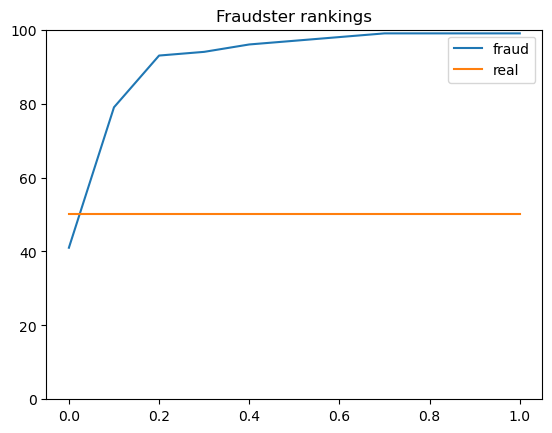

In [29]:
# delta degrees

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        ratings = ap.rate_deltaDegrees(G)
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"delta degrees",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

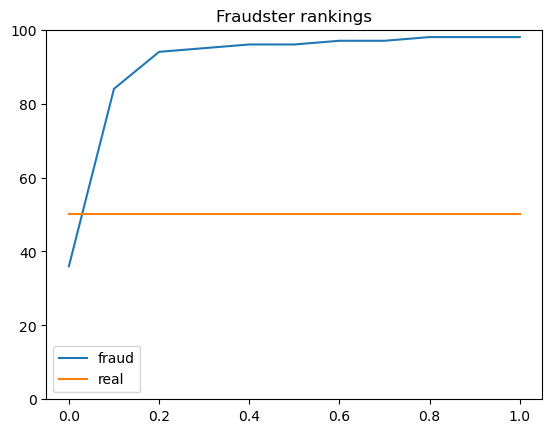

In [30]:
# f_alpha_t

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_f_alpha_t(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"f_alpha_t",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

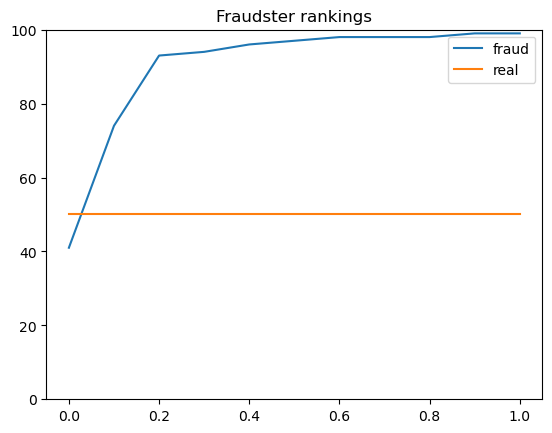

In [31]:
# MLP

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_mlp(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"MLP",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

/tmp/ipykernel_71406/1507022104.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1507022104.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1507022104.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/1507022104.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/1507022104.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp

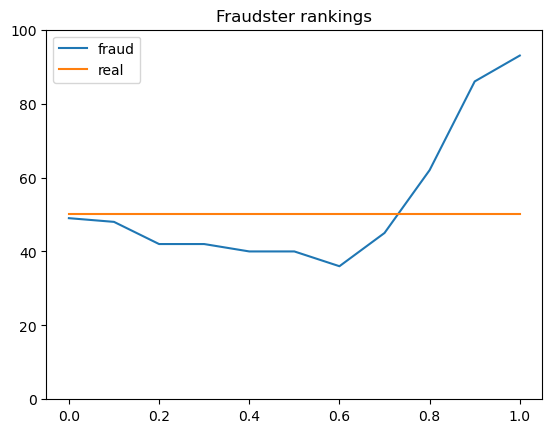

In [32]:
# MLP neighbourhood information

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model_mlp_neighbourhood(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        ratings = s.values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"MLP_neighbourhood",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

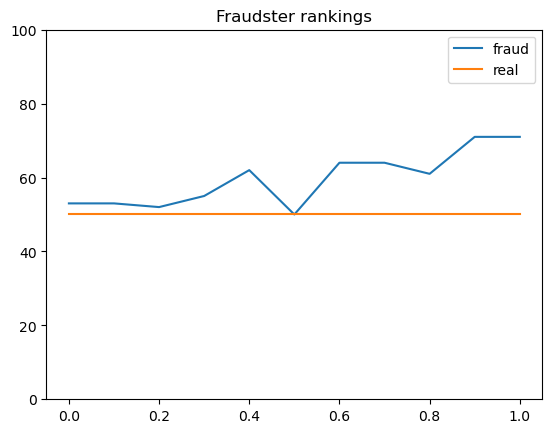

In [33]:
# PageRank

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        pr = nx.pagerank(G)
        ratings = pd.Series(pr).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"PageRank",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

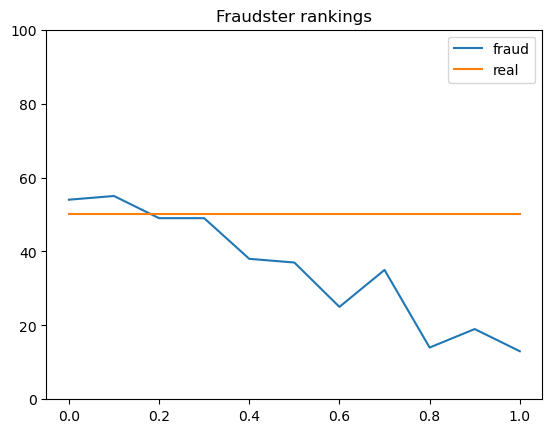

In [34]:
# GCN

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-dumb-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        data = convert_nxToPyGData(G)
        ratings = pd.Series(model_gcn(data).flatten().detach().numpy(), index=data.id.detach().numpy()).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])

l_fraudster_rankings.append({"network":"strength",
                             "method":"GCN",
                             "fraudster_type":"dumb",
                             "fraudster_rankings":fraudster_rankings})

### 2.2.2 Malicious fraudster

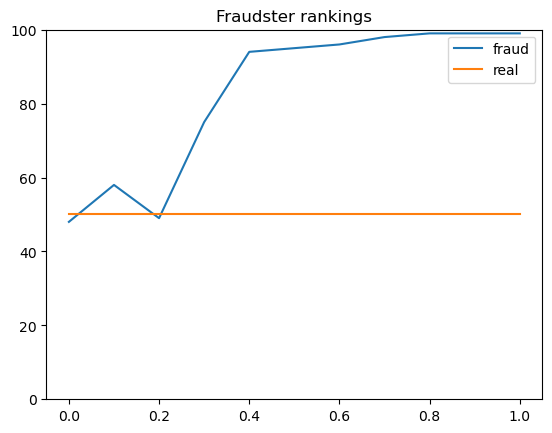

In [35]:
# delta degrees

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        ratings = ap.rate_deltaDegrees(G)
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"delta degrees",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

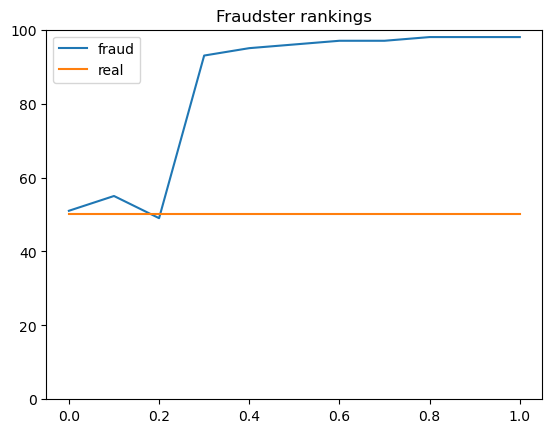

In [36]:
# f_alpha_t

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_f_alpha_t(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"f_alpha_t",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

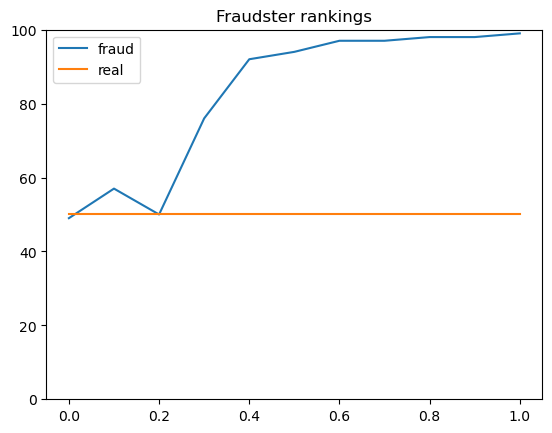

In [37]:
# MLP

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model_mlp(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_values(by="strength")["pred_strength"].values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"MLP",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

/tmp/ipykernel_71406/61902151.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/61902151.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/61902151.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_71406/61902151.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_71406/61902151.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel

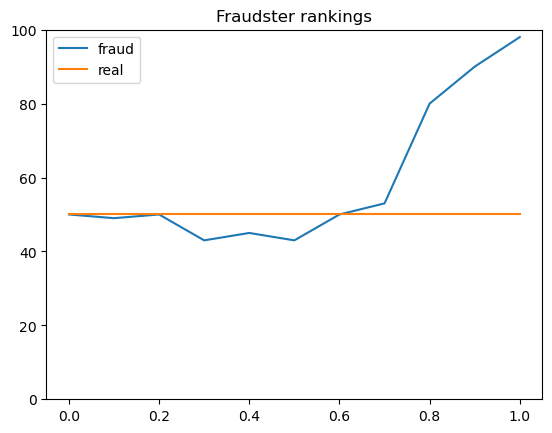

In [38]:
# MLP neighbourhood information

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model_mlp_neighbourhood(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        ratings = s.values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"MLP_neighbourhood",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

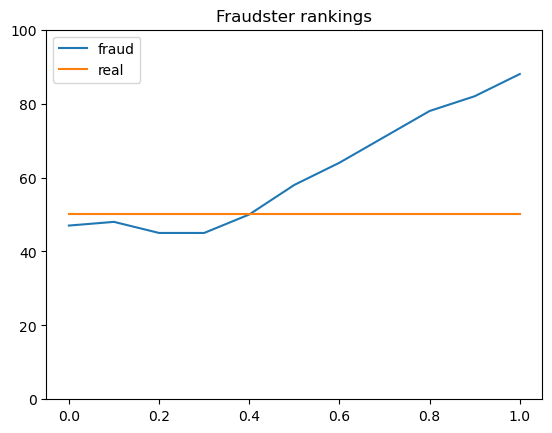

In [39]:
# PageRank

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        pr = nx.pagerank(G)
        ratings = pd.Series(pr).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])
l_fraudster_rankings.append({"network":"strength",
                             "method":"PageRank",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

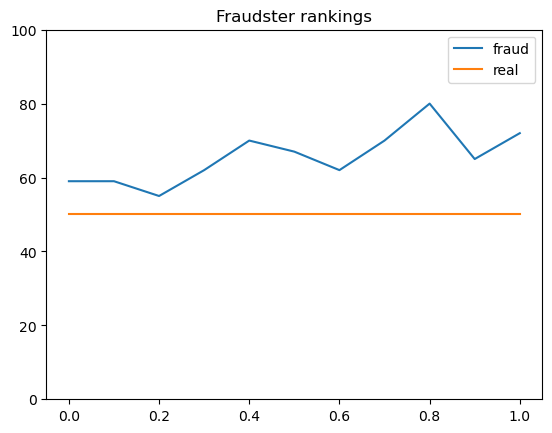

In [40]:
# GCN

l2 = []
for fraud_proba in LIST_FRAUD_PROBABILITIES:
    l1 = []
    for i in range(LEN_TEST_DATASET):
        with open(f"data/synthetic-dataset/strength-net-malicious-fraudster/test/{fraud_proba}/G_{i}.pickle", "rb") as f:
            G = pickle.load(f)
        data = convert_nxToPyGData(G)
        ratings = pd.Series(model_gcn(data).flatten().detach().numpy(), index=data.id.detach().numpy()).sort_index().values
        l1.append(ratings)
    l2.append(l1)
a = np.array(l2)
fraudster_rankings = np.nonzero(np.argsort(a.mean(axis=1))==FRAUDSTER_INDEX)[1]

plt.title("Fraudster rankings")
plt.plot(LIST_FRAUD_PROBABILITIES, fraudster_rankings, label="fraud")
plt.plot(LIST_FRAUD_PROBABILITIES, [FRAUDSTER_INDEX for _ in range(len(fraudster_rankings))], label="real")
plt.legend()
plt.ylim([0,N])

l_fraudster_rankings.append({"network":"strength",
                             "method":"GCN",
                             "fraudster_type":"malicious",
                             "fraudster_rankings":fraudster_rankings})

## 2.3 Fraud detection

### 2.3.1 Dumb fraudster

### 2.3.2 Malicious fraudster

# Staging

In [94]:
df = pd.DataFrame(l_ranking_performance)
df["spearman_r (error)"] = 1.96*df["spearman_r (std)"] / np.sqrt(LEN_TEST_DATASET)
df

,network,method,kendall_tau_distance (mean),kendall_tau_distance (std),spearman_r (mean),spearman_r (std),spearman_r (error)
0,random,delta degrees,711.11,53.160680,0.897128,0.014895,0.002919
1,random,f_alpha_t,737.28,82.216796,0.872523,0.034374,0.006737
2,random,MLP,632.63,58.030277,0.912947,0.016368,0.003208
3,random,MLP_neighbourhood,485.64,44.210524,0.948006,0.009671,0.001896
4,random,PageRank,614.01,54.247856,0.916269,0.015411,0.003021
5,random,GCN,788.72,87.724350,0.872583,0.027305,0.005352
6,strength,delta degrees,1780.74,95.592533,0.397028,0.052543,0.010298
7,strength,f_alpha_t,1790.70,102.415575,0.382554,0.056547,0.011083
8,strength,MLP,1775.64,97.368529,0.400388,0.055088,0.010797
9,strength,MLP_neighbourhood,1137.98,167.687327,0.709476,0.075105,0.014721


Text(0.5, 1.0, 'Ranking performance')

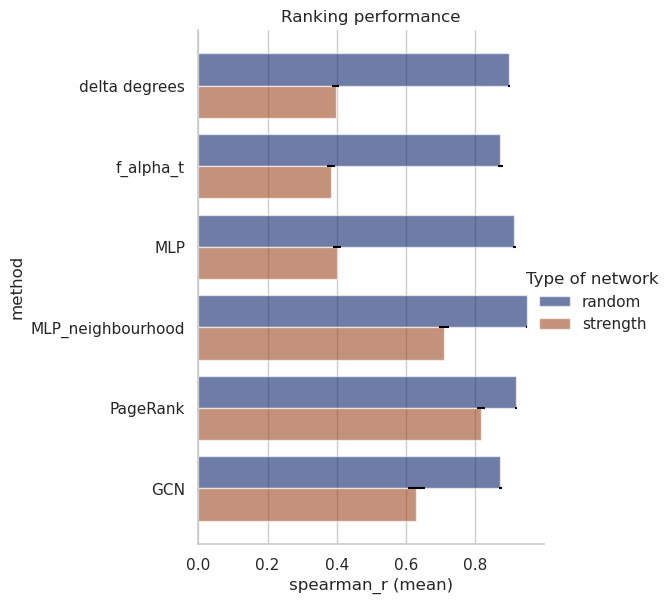

In [102]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df, kind="bar",
    y="method", x="spearman_r (mean)", hue="network",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.legend.set_title("Type of network")
plt.errorbar(x=df["spearman_r (mean)"], y=df["method"], xerr=df["spearman_r (error)"], fmt='none', color='black')
plt.title("Ranking performance")

# <>

In [103]:
df_fraudster_rankings = pd.DataFrame(l_fraudster_rankings)
df_fraudster_rankings

,network,method,fraudster_type,fraudster_rankings
0,random,delta degrees,dumb,"[50, 55, 58, 66, 68, 72, 78, 83, 87, 93, 97]"
1,random,f_alpha_t,dumb,"[52, 55, 58, 65, 68, 71, 79, 84, 87, 94, 98]"
2,random,MLP,dumb,"[50, 54, 58, 66, 67, 70, 79, 83, 87, 94, 98]"
3,random,MLP_neighbourhood,dumb,"[51, 51, 55, 58, 59, 63, 65, 70, 72, 78, 85]"
4,random,PageRank,dumb,"[51, 53, 56, 57, 57, 58, 61, 63, 63, 64, 66]"
5,random,GCN,dumb,"[51, 52, 51, 51, 49, 54, 49, 55, 54, 54, 51]"
6,random,delta degrees,malicious,"[51, 54, 62, 64, 70, 71, 77, 83, 88, 94, 98]"
7,random,f_alpha_t,malicious,"[50, 55, 61, 64, 70, 71, 81, 84, 88, 90, 98]"
8,random,MLP,malicious,"[51, 54, 62, 62, 70, 71, 78, 82, 88, 93, 98]"
9,random,MLP_neighbourhood,malicious,"[51, 52, 61, 63, 67, 71, 77, 79, 86, 91, 97]"


In [122]:
df = pd.concat([df_fraudster_rankings.drop(columns=["fraudster_rankings"]), pd.DataFrame(df_fraudster_rankings["fraudster_rankings"].apply(lambda x : tuple(x)).tolist(), columns=LIST_FRAUD_PROBABILITIES)], axis=1)
df = pd.melt(df, id_vars=["network", "method", "fraudster_type"]).rename(columns={"variable":"fraud_proba", "value":"fraudster_ranking"})
df

,network,method,fraudster_type,fraud_proba,fraudster_ranking
0,random,delta degrees,dumb,0.0,50
1,random,f_alpha_t,dumb,0.0,52
2,random,MLP,dumb,0.0,50
3,random,MLP_neighbourhood,dumb,0.0,51
4,random,PageRank,dumb,0.0,51
...,...,...,...,...,...
259,strength,f_alpha_t,malicious,1.0,98
260,strength,MLP,malicious,1.0,99
261,strength,MLP_neighbourhood,malicious,1.0,98
262,strength,PageRank,malicious,1.0,88


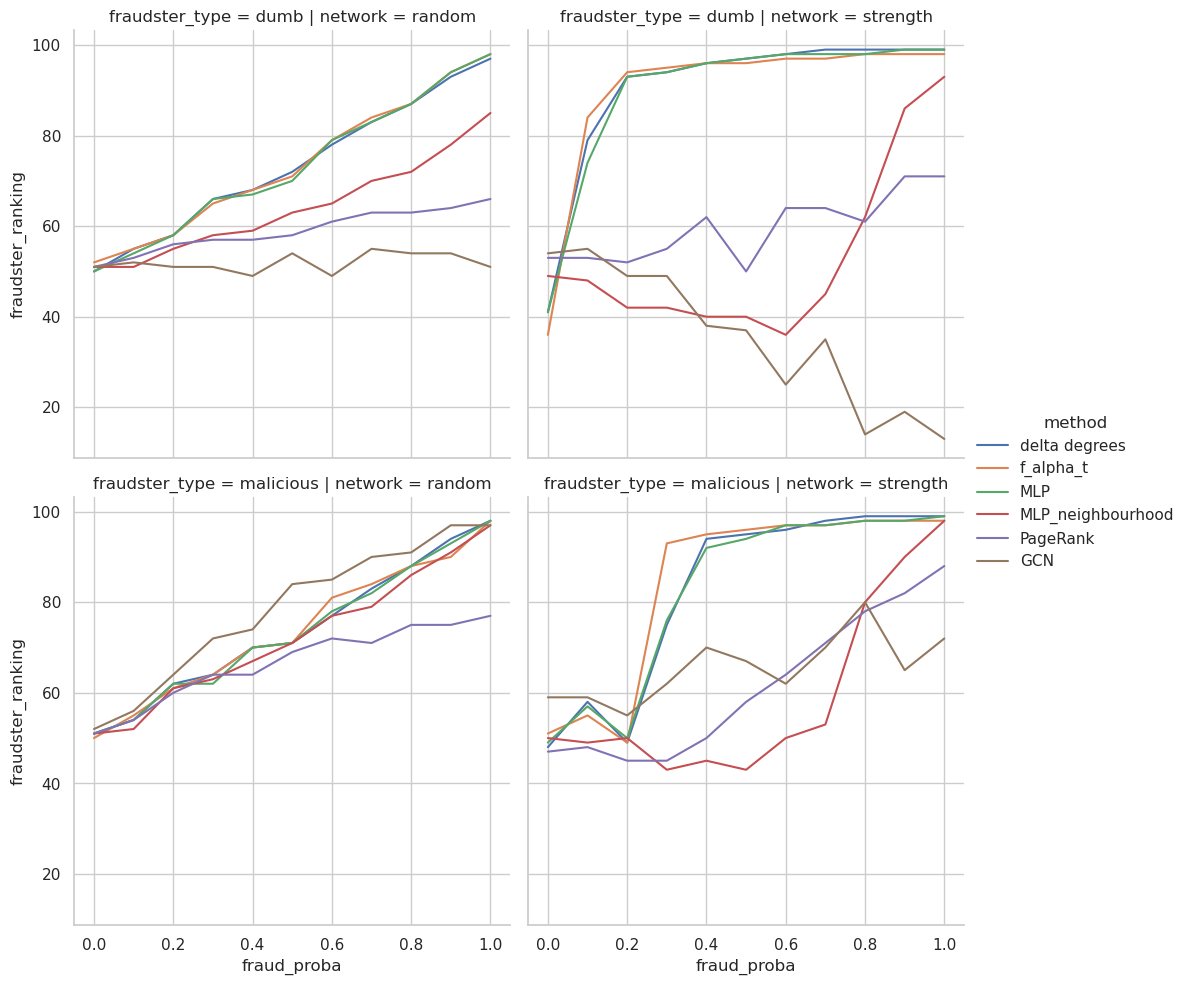

In [125]:
sns.relplot(kind="line", data=df, x="fraud_proba", y="fraudster_ranking", col="network", row="fraudster_type", hue="method")

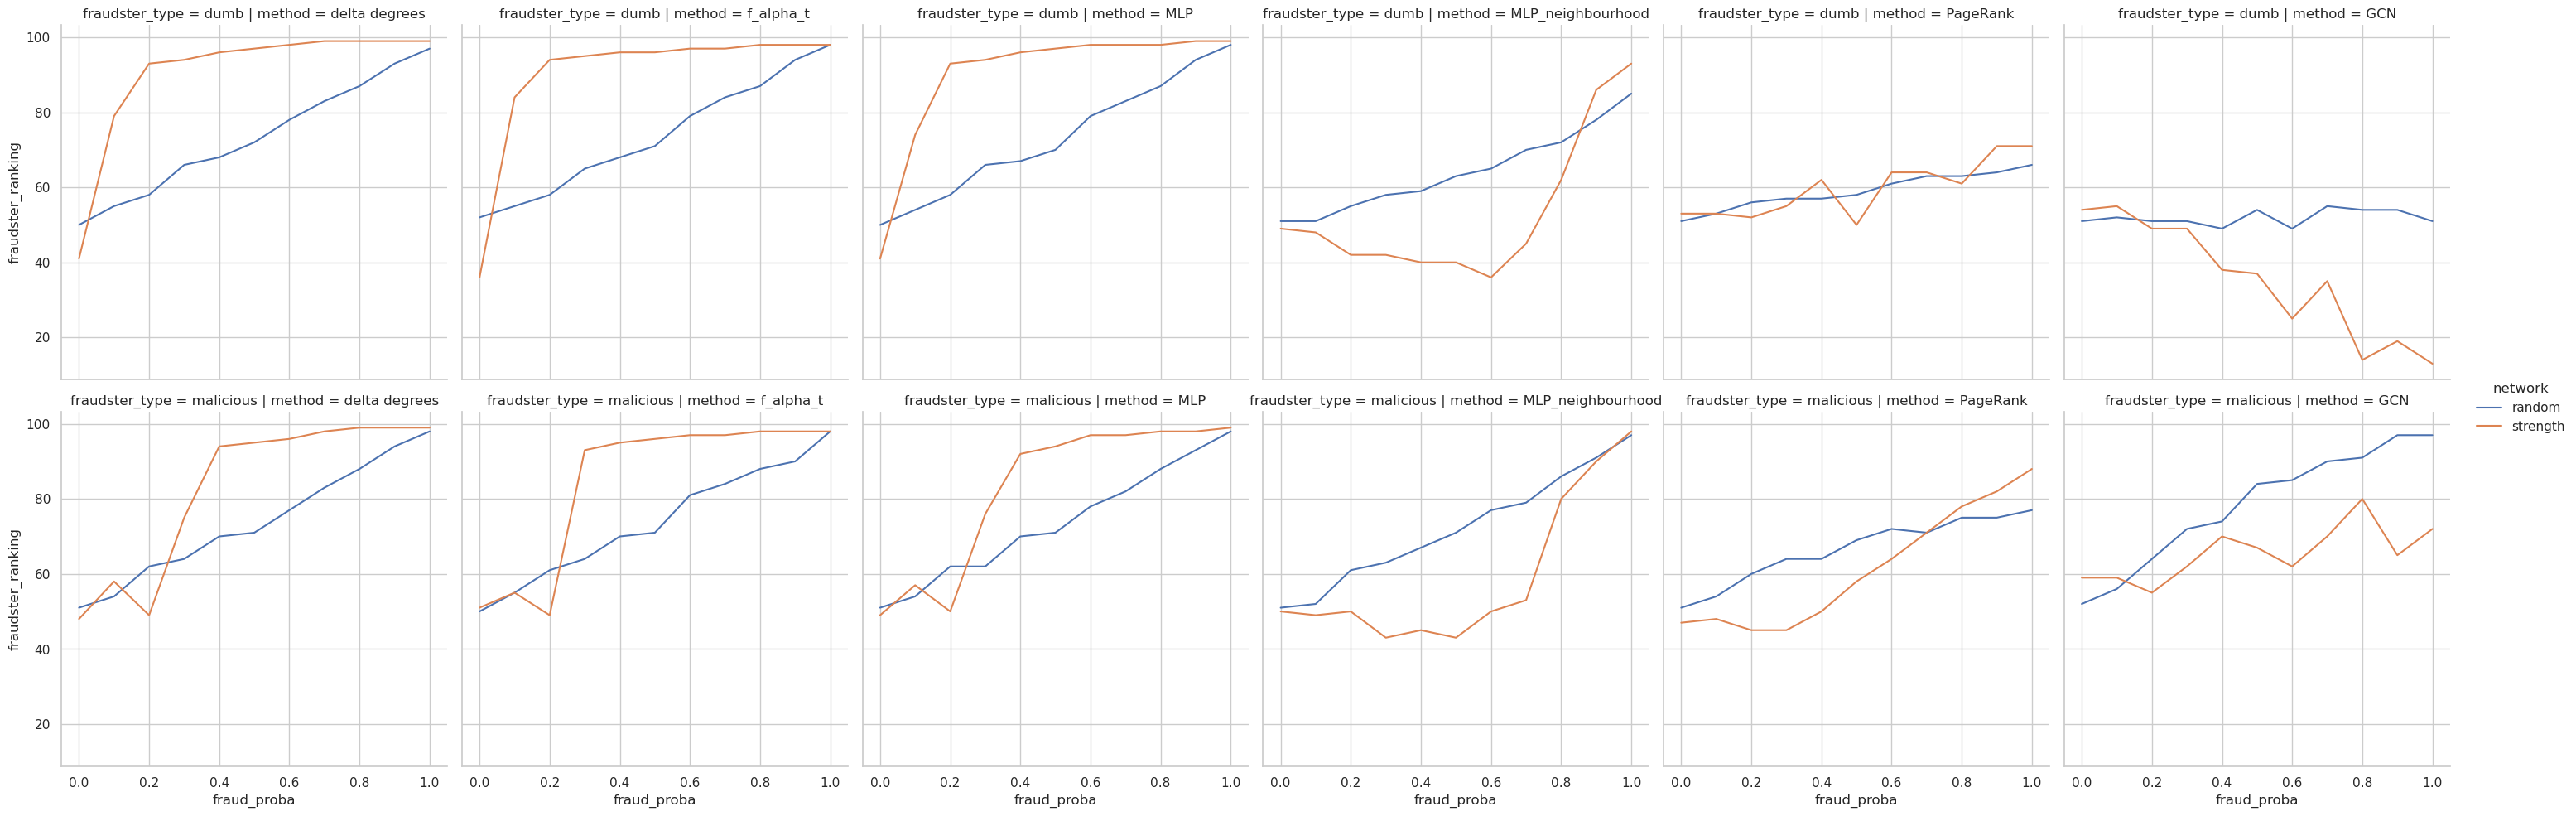

In [126]:
sns.relplot(kind="line", data=df, x="fraud_proba", y="fraudster_ranking", col="method", row="fraudster_type", hue="network")

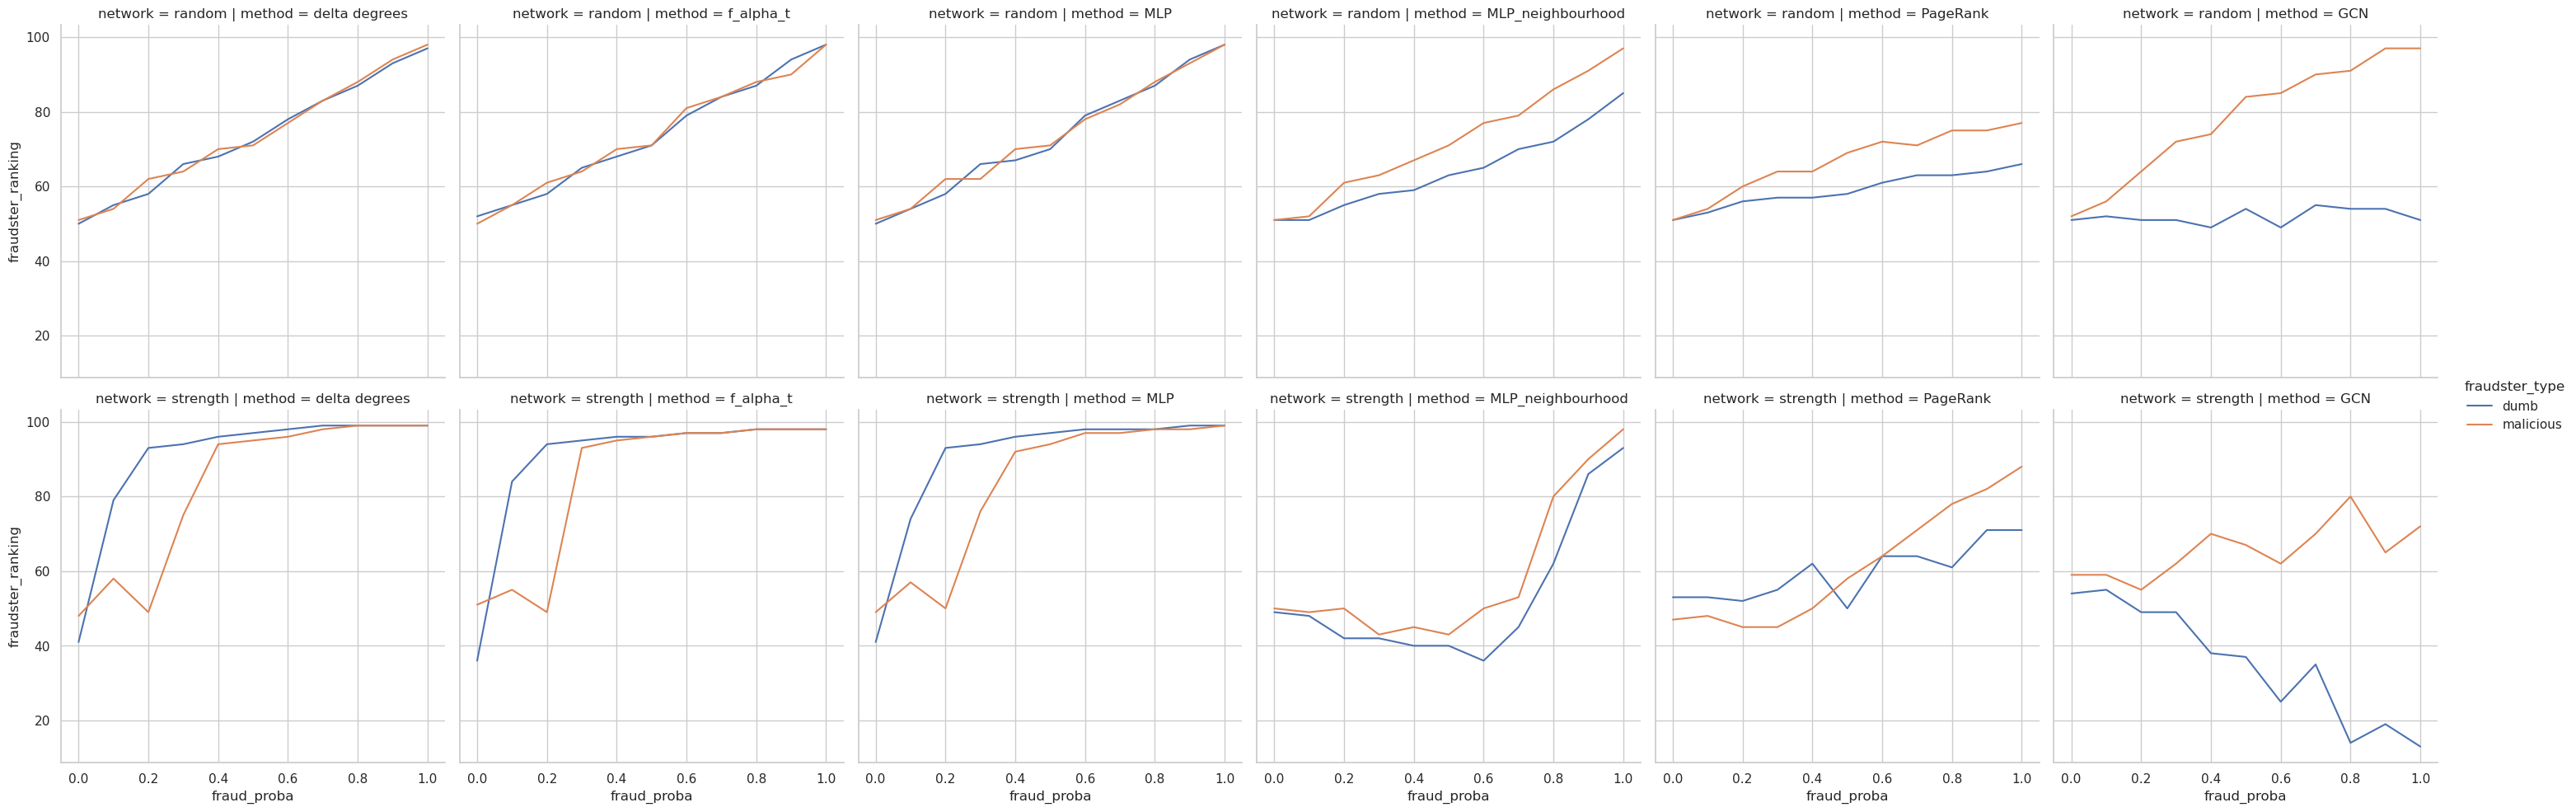

In [127]:
sns.relplot(kind="line", data=df, x="fraud_proba", y="fraudster_ranking", col="method", row="network", hue="fraudster_type")